# TTRAK HİSSE SENEDİ

Bu çalışmada **TTRAK** hisse senedinin "2021-01-01", "2024-01-01" tarihleri arasındaki kapanış fiyatlarının farklı makine öğrenimi modelleriyle tahminleri yapılacak, bu tahminler üzerinden iyileştirmeler yapılarak analiz yapılacaktır.

In [12]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [13]:
#import yfinance as yf
#df = yf.download("TTRAK.IS", start="2021-01-01", end="2024-01-01");

In [14]:
df = pd.read_csv("TTRAK.IS.csv")

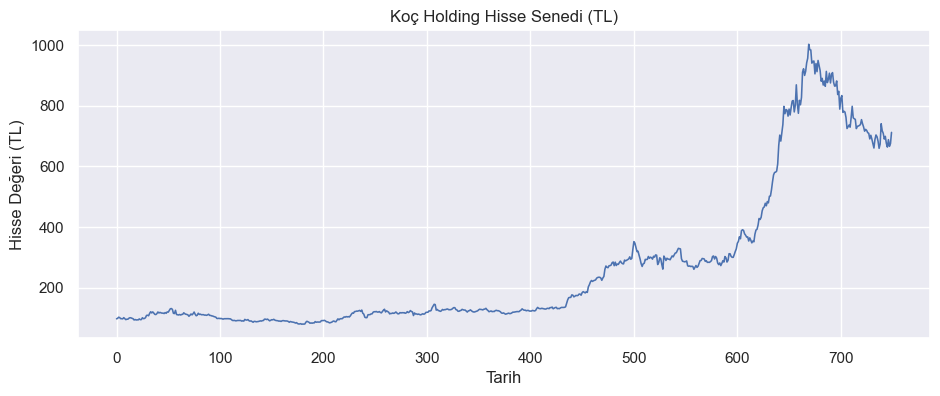

In [15]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("Koç Holding Hisse Senedi (TL)")
plt.show();

In [16]:
# Eğitim-Doğrulama-Test seti olarak bölelim:   85-7.5-7.5
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

In [17]:
len(train), len(validation), len(test)

(636, 57, 57)

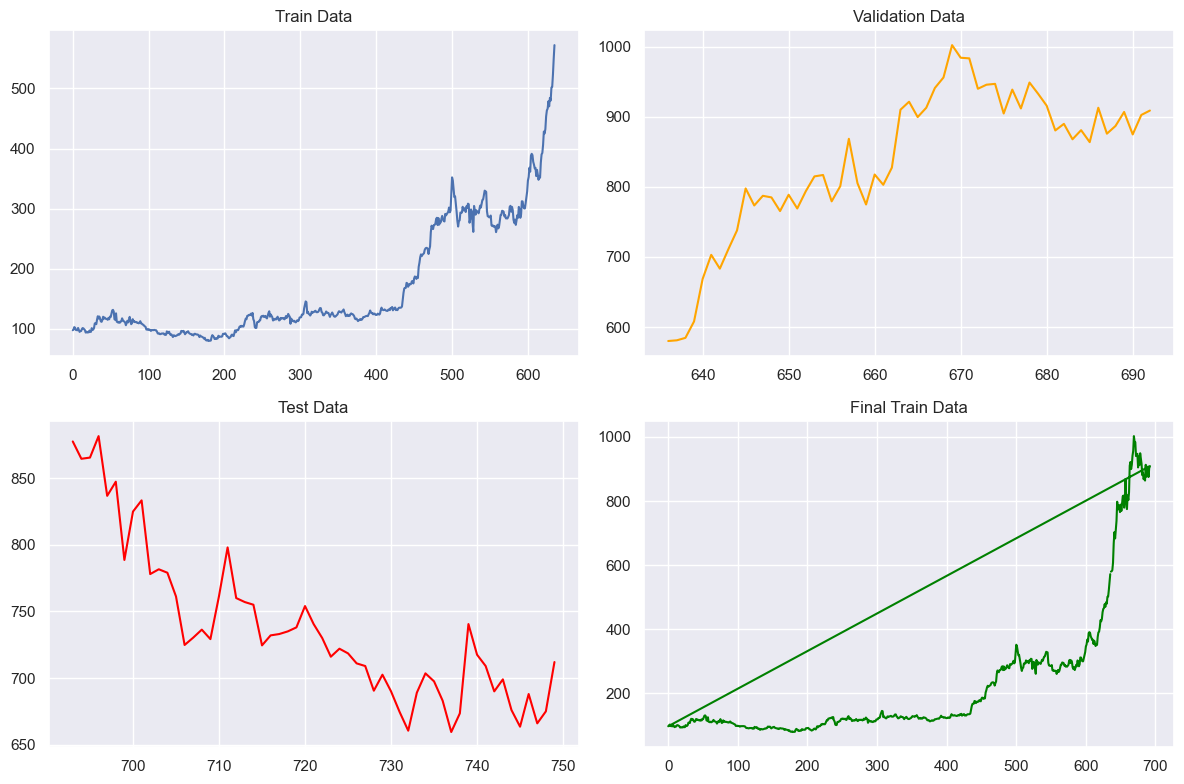

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL 

## SES MODEL PARAMETRE OPTİMİZASYONU

In [19]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
len(train), len(validation), len(test)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation)) # best_alpha: 0.99 best_mae: 266.4785

best_alpha: 0.99 best_mae: 266.4785


### ONE STEP AHEAD METHOD(SES)

In [20]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
ttrak_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    output = model_fit.forecast()
    yhat = output[0]
    ttrak_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SES MODEL HATASI

In [21]:
ttrak_ses_rmse = np.sqrt(mean_squared_error(test,ttrak_ses_model_predictions)) 
test = np.array(test)
ttrak_ses_model_predictions = np.array(ttrak_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
ttrak_ses_mape = mape(test,ttrak_ses_model_predictions) # MAPE =  2.9295321162956576
print(ttrak_ses_mape)

2.9295321162956576


### SES MODELİNİN TAHMİN GRAFİĞİ:

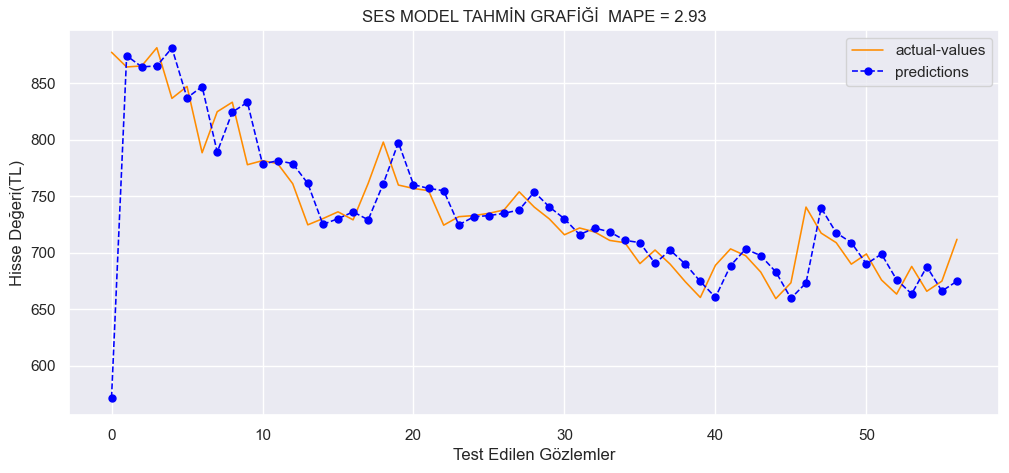

In [22]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(ttrak_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_ses_mape,3)))
plt.legend();

SES MODEL tahminleri mavi, gerçek değerler sarı renkli belirtilmiştir.  

# DES MODEL

## DES MODEL PARAMETRE OPTİMİZASYONU

In [23]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.06 best_beta: 0.99 best_mae: 71.3049

best_alpha: 0.06 best_beta: 0.99 best_mae: 71.3049


### ONE STEP AHEAD METHOD(DES)

In [24]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
ttrak_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    ttrak_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### DES MODEL HATASI

In [25]:
ttrak_des_rmse = np.sqrt(mean_squared_error(test,ttrak_des_model_predictions)) # RMSE = 10.320334750984863
test = np.array(test)
ttrak_des_model_predictions = np.array(ttrak_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
ttrak_des_mape = mape(test,ttrak_des_model_predictions)
print(ttrak_des_mape) # MAPE = 14.614475789114637

14.614475789114637


### DES MODEL TAHMİN GRAFİĞİ:

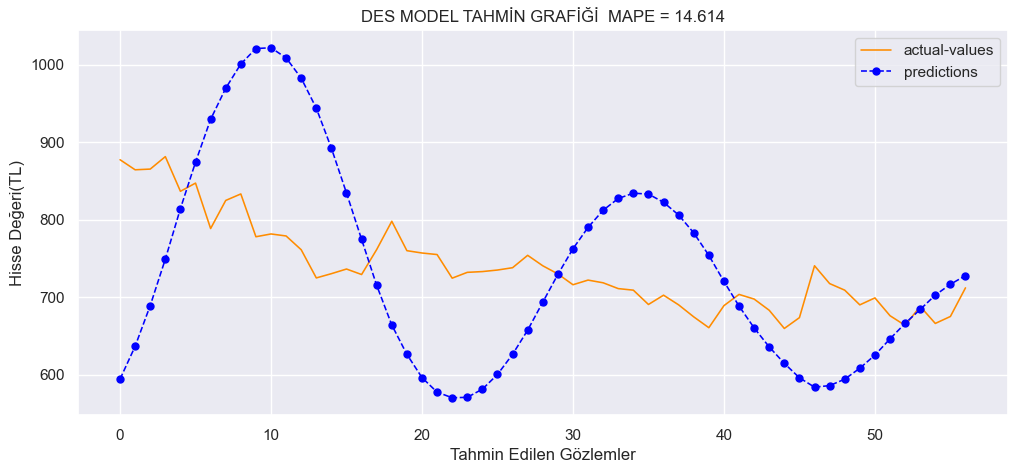

In [26]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(ttrak_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_des_mape,3)))
plt.legend();

# TES MODEL

## TES MODEL PARAMETRE OPTİMİZASYONU

In [27]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
# best_alpha: 0.11 best_beta: 0.51 best_gamma: 0.21 best_mae: 79.3327

best_alpha: 0.11 best_beta: 0.51 best_gamma: 0.21 best_mae: 79.3327


### ONE STEP AHEAD METHOD

In [28]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
ttrak_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    ttrak_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### TES MODEL HATASI

In [29]:
ttrak_tes_rmse = np.sqrt(mean_squared_error(test,ttrak_tes_model_predictions)) # RMSE = 4.622969967001846
test = np.array(test)
ttrak_tes_model_predictions = np.array(ttrak_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
ttrak_tes_mape = mape(test,ttrak_tes_model_predictions)
print(ttrak_tes_mape) # MAPE = 8.944686103888145

8.944686103888145


### TES MODEL TAHMİN GRAFİĞİ:

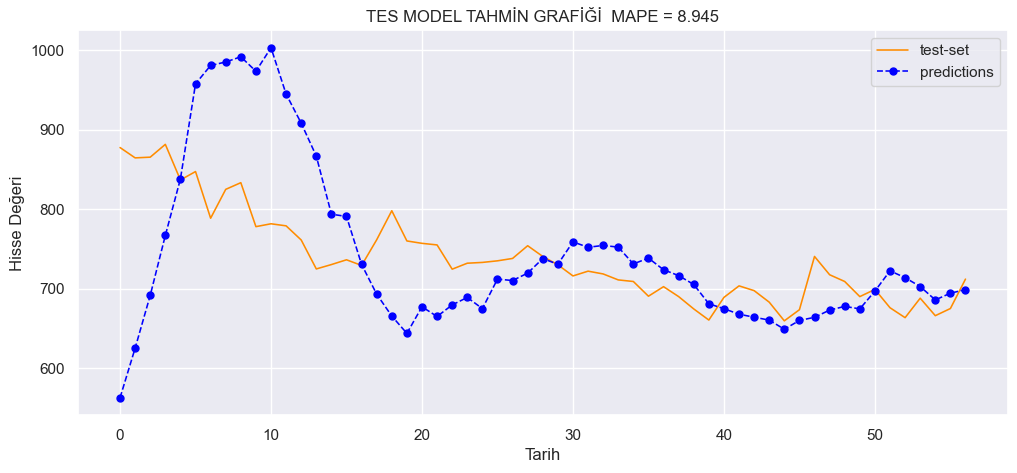

In [30]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(ttrak_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_tes_mape,3)))
plt.legend();

# ARIMA MODEL
## ARIMA MODEL PARAMETRE OPTİMİZASYONU

In [31]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(2, 2, 3) AIC=4108.90  <- parametreler.

Best ARIMA(2, 2, 3) AIC=4108.90


### ONE STEP AHEAD METHOD

In [32]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
ttrak_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    ttrak_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### ARIMA MODEL HATASI

In [33]:
ttrak_arima_rmse = np.sqrt(mean_squared_error(test,ttrak_arima_model_predictions)) # RMSE = 3.1332348079593957
test = np.array(test)
ttrak_arima_model_predictions = np.array(ttrak_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
ttrak_arima_mape = mape(test,ttrak_arima_model_predictions) 
print(ttrak_arima_mape) # MAPE = 3.0636180093869396

3.0636180093869396


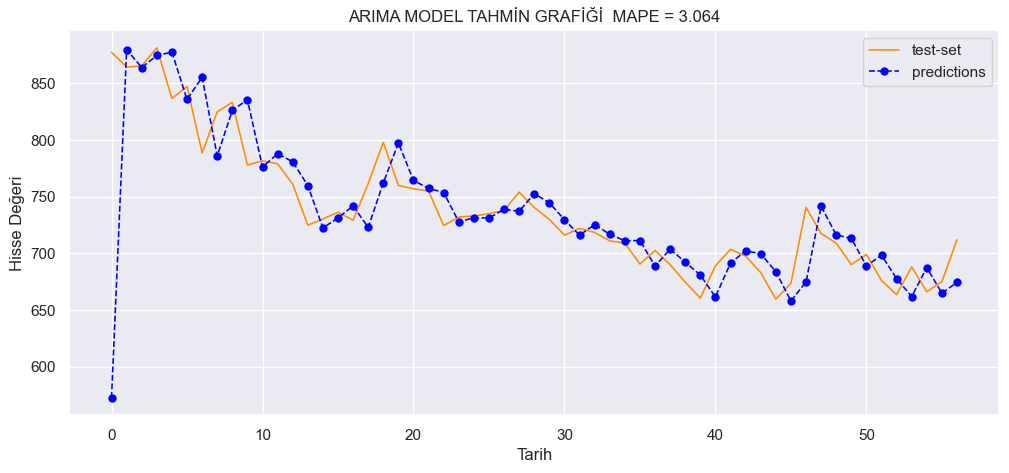

In [34]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(ttrak_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_arima_mape,3)))
plt.legend();

# SARIMA MODEL
## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [35]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# SARIMA(0, 1, 1)x(0, 1, 1, 5)12 - AIC:4105.280397799163 <- parametreler.

SARIMA(0, 1, 1)x(0, 1, 1, 5)12 - AIC:4105.280397799163


### ONE STEP AHEAD METHOD

In [36]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
ttrak_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    ttrak_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SARIMA MODEL HATASI

In [37]:
ttrak_sarima_rmse = np.sqrt(mean_squared_error(test,ttrak_sarima_model_predictions)) # RMSE = 3.13743723917444
test = np.array(test)
ttrak_sarima_model_predictions = np.array(ttrak_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
ttrak_sarima_mape = mape(test,ttrak_sarima_model_predictions) 
print(ttrak_sarima_mape) # MAPE = 2.8548468087347434

2.8548468087347434


### SARIMA MODEL TAHMİN GRAFİĞİ

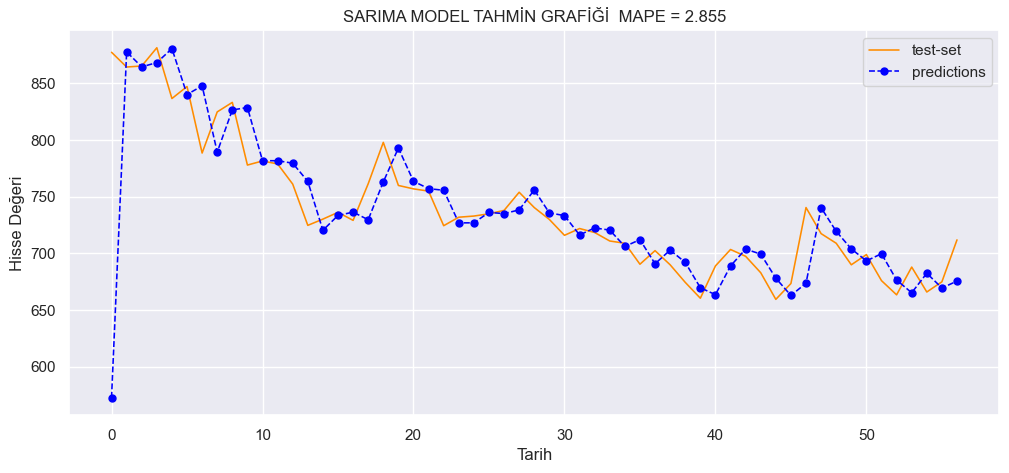

In [38]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(ttrak_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [39]:
data = pd.read_csv("TTRAK.IS.csv")
prices = data['Close'].values

### Veri Ölçeklendirme

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

### ONE STEP AHEAD METHOD DATA CREATION

In [41]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 10

### Veri Bölümlemesi

In [42]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(693, 693, 67)

In [43]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0804 - val_loss: 0.0701
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3427e-04 - val_loss: 0.0014
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8698e-04 - val_loss: 0.0018
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6022e-04 - val_loss: 0.0018
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3752e-04 - val_loss: 0.0019
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1921e-04 - val_loss: 0.0019
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0394e-04 - val_loss: 0.0020
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9050e-04 - val_loss: 0.0020
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7913e-04 - val_loss: 0.0020
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6967e-04 - val_loss: 0.0020
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━

### ANN MODEL HATASI

In [45]:
ttrak_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(ttrak_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
ttrak_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(ttrak_ann_mape) # MAPE = 6.750136445578068

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4.1543721823852024


In [46]:
test = np.array(y_test_inverse)
ttrak_ann_model_predictions = np.array(y_pred_ann_inverse)

### ANN MODEL TAHMİN GRAFİĞİ

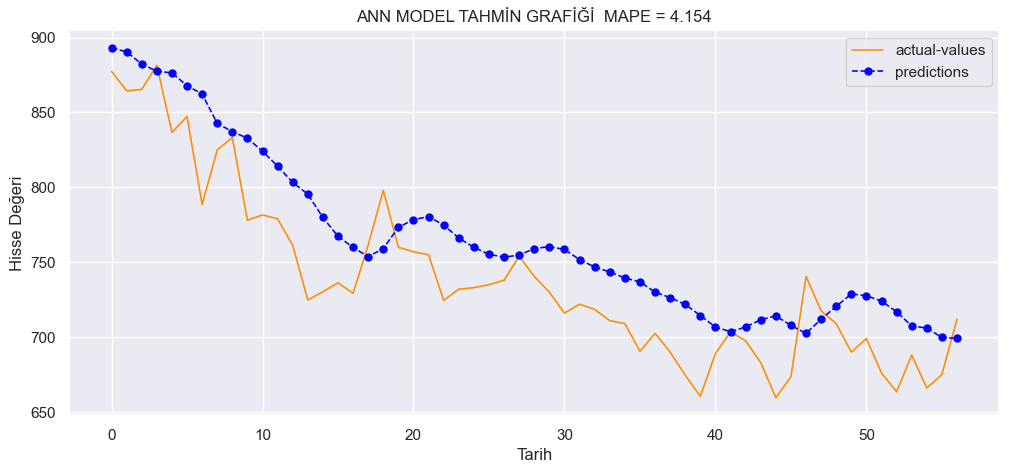

In [47]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(ttrak_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_ann_mape,3)))
plt.legend();

# CNN MODEL


In [48]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [49]:
data = pd.read_csv("TTRAK.IS.csv")
prices = data["Close"].values

In [50]:
# Parametreler
lookback = 10
test_size = 57
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [51]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [52]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [53]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - val_loss: 0.0048
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 6.1664e-04 - val_loss: 0.0056
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 6.1517e-04 - val_loss: 0.0057
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 5.7358e-04 - val_loss: 0.0051
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 5.1378e-04 - val_loss: 0.0046
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 4.6502e-04 - val_loss: 0.0040
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 4.2115e-04 - val_loss: 0.0035
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8704e-04 - val_loss: 0.0032
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 3.6187e-04 - val_loss: 0.0028
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 3.4315e-04 - val_loss: 0.0025
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3124e-04 - val_loss: 0.0022
Epoch 12/20
43/43 

### MODEL HATASI

In [54]:
y_pred_scaled = model.predict(X_test)
ttrak_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
ttrak_cnn_mape = mape(y_test_inverse, ttrak_cnn_y_pred)
print(f"Test MAPE: {ttrak_cnn_mape}") # Test MAPE: 3.640815162291264

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test MAPE: 3.845271312866504


### CNN MODEL TAHMİN GRAFİĞİ

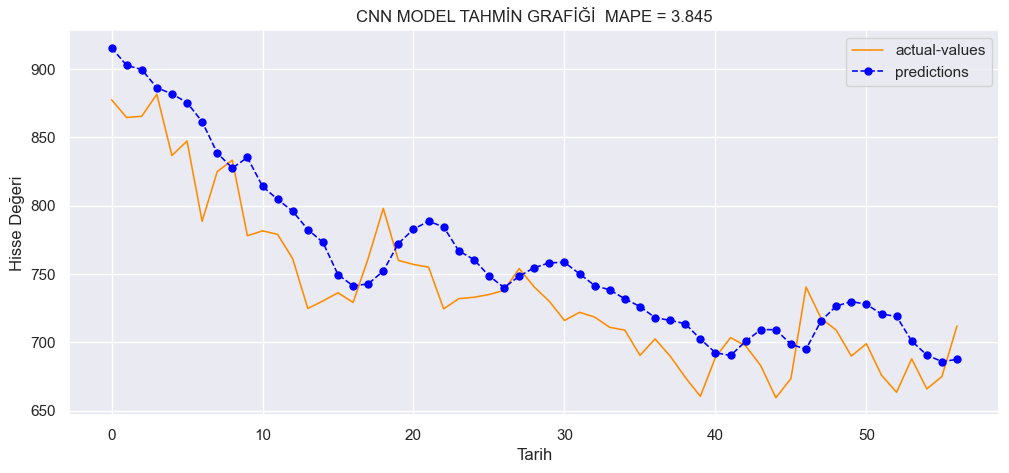

In [55]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(ttrak_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(ttrak_cnn_mape,3)))
plt.legend();

### KOMBİNASYON YÖNTEMİ VE BAŞARISI

# YÖNTEMLERİN MAPE DEĞERLERİ:

In [56]:
best_model = pd.DataFrame([ttrak_ses_mape, ttrak_des_mape, ttrak_tes_mape,
                           ttrak_arima_mape, ttrak_sarima_mape,
                           ttrak_ann_mape, ttrak_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
SARIMA MODEL        2.854847
SES MODEL           2.929532
ARIMA MODEL         3.063618
CNN MODEL           3.845271
ANN MODEL           4.154372
TES MODEL           8.944686
DES MODEL          14.614476


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [57]:
predictions = np.stack([ttrak_sarima_model_predictions.flatten(), ttrak_ses_model_predictions.flatten(), ttrak_arima_model_predictions.flatten()], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[572.31579673 877.38393904 864.43097809 869.50249593 879.89032509
 837.7355039  850.15934764 788.21740937 825.75867178 832.54551198
 778.87571548 783.77652958 779.82702678 761.59149761 722.64982626
 731.70123223 738.18429655 727.30786972 762.11077733 796.05878624
 762.80330318 757.18983337 754.81068171 726.52412083 730.11968956
 733.49105714 736.27137899 737.85827102 754.20404831 740.32505363
 731.07021131 716.15724137 723.27009427 718.66987461 709.43210757
 710.83766624 690.09986122 703.0037592  691.5028174  675.06038942
 661.92024587 689.69264993 703.11427435 698.88483785 681.71957406
 660.20046585 673.93581217 740.55229125 717.82396843 708.75070141
 690.85219081 699.01854424 676.80923336 663.58476616 685.92492994
 666.83184446 674.97282881]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [58]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) 

2.94117525851978


In [64]:
best_model = pd.DataFrame([ttrak_sarima_mape, ttrak_ses_mape,
                        ttrak_arima_mape,combined_mape],

                          index=["SARIMA MODEL", "SES MODEL","ARIMA MODEL","COMBINED PREDICTION"],

                          columns=["TTRAK MAPE Değerleri"])
print(best_model.sort_values("TTRAK MAPE Değerleri", ascending=True));

                     TTRAK MAPE Değerleri
SARIMA MODEL                     2.854847
SES MODEL                        2.929532
COMBINED PREDICTION              2.941175
ARIMA MODEL                      3.063618


In [61]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 46.4213288581592
print(combined_RMSE);

46.4213288581592


In [65]:
best_model_RMSE = pd.DataFrame([ttrak_sarima_rmse, ttrak_ses_rmse,
                           ttrak_arima_rmse, combined_RMSE],

                          index=["SARIMA MODEL", "SES MODEL","ARIMA MODEL","COMBINED PREDICTION"],

                          columns=["TTRAK RMSE Değerleri"])
print(best_model_RMSE.sort_values("TTRAK RMSE Değerleri", ascending=True));

                     TTRAK RMSE Değerleri
SARIMA MODEL                    46.077126
COMBINED PREDICTION             46.421329
SES MODEL                       46.462526
ARIMA MODEL                     46.841909


#

# KOMBİNE TAHMİNLERİN GRAFİĞİ:

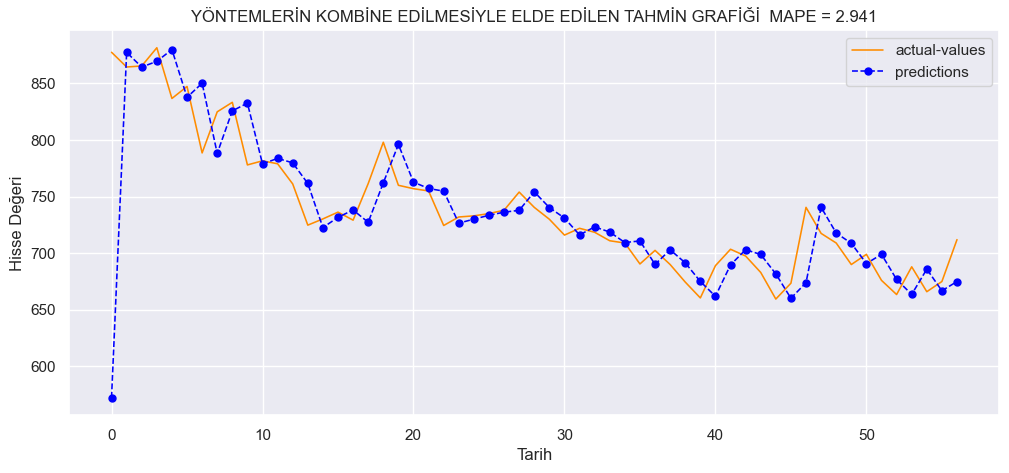

In [60]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,3)))
plt.legend();